In [17]:
import time
from datetime import datetime
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
from torchvision.transforms import Normalize

from sparse_coding_torch.conv_sparse_model import ConvSparseLayer
from sparse_coding_torch.small_data_classifier import SmallDataClassifier
from sparse_coding_torch.utils import plot_filters
from sparse_coding_torch.utils import plot_video

from sparse_coding_torch.BamcPreprocessor import BamcPreprocessor
from sparse_coding_torch.video_loader import MinMaxScaler
from sparse_coding_torch.video_loader import VideoGrayScaler
from sparse_coding_torch.video_loader import VideoLoader
from sparse_coding_torch.video_loader import VideoClipLoader

from sparse_coding_torch.load_data import load_bamc_data

from IPython.display import HTML

In [2]:
# Get the devices available and set the batch size
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    batch_size = 1
else:
    batch_size = 4*3
    # batch_size = 3

In [44]:
# batch_size = 62
# video_path = "/shared_data/bamc_data"
video_path = "/shared_data/bamc_data_scale_cropped"

# scaled and cropped video size is 400x700
transforms = torchvision.transforms.Compose([VideoGrayScaler(),
                                             MinMaxScaler(0, 255),
                                             Normalize((0.184914231300354,), (0.11940956115722656,)),
                                             # BamcPreprocessor(),
                                             torchvision.transforms.Resize(size=(200, 350))
                                            ])
dataset = VideoLoader(video_path, transform=transforms, 
                          # frames_between_clips=1,
                          #num_frames=4
                          num_frames=60
                         )

In [45]:
data = torch.stack([dataset[i][1].float() for i in range(len(dataset))])

In [46]:
data.float().max(), data.float().min()

(tensor(5.7504), tensor(-1.5486))

In [47]:
data.float().mean().item(), data.float().std().item()

(7.680491798112143e-09, 0.9966946840286255)

(array([5.6827057e+07, 7.3490907e+07, 6.7035305e+07, 3.8855535e+07,
        1.6149867e+07, 5.5648660e+06, 1.8556760e+06, 5.1971400e+05,
        9.6711000e+04, 4.3620000e+03]),
 array([-1.5485713 , -0.81867284, -0.0887743 ,  0.64112425,  1.3710227 ,
         2.1009212 ,  2.8308198 ,  3.5607183 ,  4.290617  ,  5.0205154 ,
         5.750414  ], dtype=float32),
 <BarContainer object of 10 artists>)

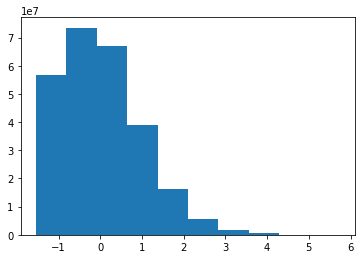

In [48]:
plt.hist(data.flatten().numpy())

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                          shuffle=True)

In [ ]:
example_data = next(iter(data_loader))
example_data[1].shape
ani = plot_video(example_data[1][2])
HTML(ani.to_html5_video())

In [ ]:
sparse_layer = ConvSparseLayer(in_channels=1,
                               out_channels=64,
                               kernel_size=(4, 16, 16),
                               stride=2,
                               padding=0,
                               convo_dim=3,
                               rectifier=True,
                               lam=0.01,
                               max_activation_iter=150,
                               activation_lr=1e-2)
model = sparse_layer
# model = torch.nn.DataParallel(model, device_ids=[1, 0, 2, 3])
model.to(device)

learning_rate = 3e-4
optimizer = torch.optim.Adam(sparse_layer.parameters(),
                                    lr=learning_rate)

criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Load models if we'd like to
checkpoint = torch.load("saved_models/sparse_conv3d_model-4x16x16x64-4x200x350-clips.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Put everything on the target device
model.to(device)

In [ ]:
loss_log = []
inner_losses = []

In [ ]:
for epoch in tqdm(range(100)):
    epoch_loss = 0
    for labels, local_batch, filenames in data_loader:
        local_batch = local_batch.to(device)

        # activations = model(local_batch)
        activations, inner_loss = model(local_batch)
        inner_losses.extend(inner_loss)
        
        loss = sparse_layer.loss(local_batch, activations)
        epoch_loss += loss.item() * local_batch.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sparse_layer.normalize_weights()
      
    epoch_loss /= len(data_loader.sampler)
    loss_log.append(epoch_loss)

In [ ]:
#plt.plot(inner_losses[0])
plt.plot(inner_losses)
plt.ylim(0, 8000)
t = 150
# plt.xlim(t*150+t, (t+1)*150)
plt.xlim(0, 150)
print(min(inner_losses))

In [ ]:
plt.plot(loss_log)

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
# Save model parameters
torch.save({
    'model_state_dict': model.module.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, datetime.now().strftime("saved_models/sparse_conv3d_model-%Y%m%d-%H%M%S.pt"))

In [ ]:
ani = plot_video(example_data[1][2])
HTML(ani.to_html5_video())

In [ ]:
idx=1
activations = sparse_layer(example_data[1][idx:idx+1].to(device))
reconstructions = sparse_layer.reconstructions(
    activations).cpu().detach().numpy()

ani = plot_video(reconstructions.squeeze(0))
# ani = plot_original_vs_recon(example_data[1][idx:idx+1], reconstructions, idx=0)
HTML(ani.to_html5_video())

In [ ]:
def plot_filters(filters):
    num_filters = filters.shape[0]
    ncol = 8
    # ncol = int(np.sqrt(num_filters))
    # nrow = int(np.sqrt(num_filters))
    T = filters.shape[2]
    
    if num_filters // ncol == num_filters / ncol:
        nrow = num_filters // ncol
    else:
        nrow = num_filters // ncol + 1

    fig, axes = plt.subplots(ncols=ncol, nrows=nrow,
                             constrained_layout=True,
                             figsize=(ncol*2, nrow*2))

    ims = {}
    for i in range(num_filters):
        r = i // ncol
        c = i % ncol
        ims[(r, c)] = axes[r, c].imshow(filters[i, 0, 0, :, :],
                                        cmap=cm.Greys_r)

    def update(i):
        t = i % T
        for i in range(num_filters):
            r = i // ncol
            c = i % ncol
            ims[(r, c)].set_data(filters[i, 0, t, :, :])

    return FuncAnimation(plt.gcf(), update, save_count=filters.shape[2],
                         interval=1000/20)

In [ ]:
ani = plot_filters(sparse_layer.filters.cpu().detach())
HTML(ani.to_html5_video())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SmallDataClassifier(nn.Module):
    
    def __init__(self, sparse_layer):
        super().__init__()

        self.sparse_layer = sparse_layer
        
        self.pool = nn.MaxPool3d(2, 2)
        
        self.dropout3d = torch.nn.Dropout3d(p=0.1, inplace=False)
        self.dropout = torch.nn.Dropout(p=0.5, inplace=False)
        
        # First fully connected layer
        self.fc1 = nn.Linear(5462100, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    # x represents our data
    def forward(self, x):
        # Pass data through conv1
        activations = self.sparse_layer(x)
        
        # x = self.dropout3d(x)
        
        # Flatten x with start_dim=1
        x = torch.flatten(activations, 1)
        
        # print(x.shape)
        
        # Pass data through fc1
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x, activations

In [ ]:
# Build a frozen sparse layer then add a small data classifier on top
frozen_sparse = ConvSparseLayer(in_channels=1,
                                out_channels=25,
                                kernel_size=(20, 16, 16),
                                stride=(2, 4, 4),
                                padding=0,
                                convo_dim=3,
                                rectifier=True,
                                shrink=0.25,
                                lam=0.25,
                                max_activation_iter=200,
                                activation_lr=1e-2)
sparse_param = torch.load("saved_models/sparse_conv3d_model-best.pt")
frozen_sparse.load_state_dict(sparse_param['model_state_dict'])
        
for param in frozen_sparse.parameters():
    param.requires_grad = False

predictive_model = torch.nn.DataParallel(SmallDataClassifier(frozen_sparse), device_ids=[0,1,2,3])
predictive_model.to(device)

learning_rate = 1e-2
prediction_optimizer = torch.optim.Adam(predictive_model.parameters(),
                                        lr=learning_rate)

criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
device = "cuda:0"
predictive_model.to(device)

idx=3
predictive_model(example_data[1][idx:idx+1].to(device))

In [ ]:
model.train()
for epoch in range(3):
    epoch_loss = 0
    # for local_batch in train_loader:
    t1 = time.perf_counter()
    for labels, local_batch in train_loader:
        local_batch = local_batch.to(device)
        
        torch_labels = torch.zeros(len(labels))
        torch_labels[[i for i in range(len(labels)) if labels[i] == 'PTX_No_Sliding']] = 1
        torch_labels = torch_labels.unsqueeze(1).to(device)
        
        pred, activations = predictive_model(local_batch)
        
        loss = criterion(pred, torch_labels)
        # loss += frozen_sparse.loss(local_batch, activations)
        epoch_loss += loss.item() * local_batch.size(0)
        
        prediction_optimizer.zero_grad()
        loss.backward()
        prediction_optimizer.step()
        
    t2 = time.perf_counter()
    print('epoch={}, time={:.2f}, loss={:.2f}'.format(epoch, t2-t1, loss))

In [ ]:
model.eval()
with torch.no_grad():
    epoch_loss = 0
    
    y_h = None
    y = None
    
    error = None
    
    t1 = time.perf_counter()
    # for local_batch in train_loader:
    for labels, local_batch in test_loader:
        local_batch = local_batch.to(device)

        torch_labels = torch.zeros(len(labels))
        torch_labels[[i for i in range(len(labels)) if labels[i] == 'PTX_No_Sliding']] = 1
        torch_labels = torch_labels.unsqueeze(1).to(device)

        
        pred, _ = predictive_model(local_batch)
        
        loss = criterion(pred, torch_labels)
        epoch_loss += loss.item() * local_batch.size(0)

        if error is None:
            error = torch.abs(torch_labels - torch.nn.Sigmoid()(pred).round()).flatten()
            y_h = torch.nn.Sigmoid()(pred).round().flatten()
            y = torch_labels.flatten()
        else:
            error = torch.cat((error, torch.abs(torch_labels - torch.nn.Sigmoid()(pred).round()).flatten()))
            y_h = torch.cat((y_h, torch.nn.Sigmoid()(pred).round().flatten()))
            y = torch.cat((y, torch_labels.flatten()))
            
    t2 = time.perf_counter()
    
    print('loss={:.2f}, time={:.2f}'.format(loss, t2-t1))
        
    print("Overall error={:.2f}".format(error.mean()))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y.cpu(), y_h.cpu())

cm_display = ConfusionMatrixDisplay(cm).plot()